#### International Conference on Machine Learning (ICML), 2020.

## Frequentist Uncertainty in Recurrent Neural Networks via Blockwise Influence Functions

*Ahmed M. Alaa and Mihaela van der Schaar*

Recurrent neural networks (RNNs) are instrumental in modelling sequential and time-series data. Yet, when using RNNs to inform decision-making,  predictions by themselves are not sufficient — we also need estimates of predictive uncertainty. The *blockwise Jackknife* method capitalizes on ideas from classical jackknife resampling to develop a frequentist approach for quantifying uncertainty in RNN predictions. This approach does not interfere with model training or compromise its accuracy, and applies to any RNN architecture. The blockwise Jackknife operates by estimating the variability of the (jackknife) sampling distribution of the RNN outputs, which is estimated by repeatedly deleting “blocks” of (temporally-correlated) training data, and collecting the predictions of the RNN re-trained on the remaining data. To avoid exhaustive re-training, we utilize *influence functions* to estimate the effect of removing training data blocks on the learned RNN parameters. This notebook provides a tutorial on how to use our method through a synthetic data example.

#### Step 1: Import all necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch

from models.rnn import RNN     # library containing the base RNN model implementation in torch
from models.uncertainty import RNN_uncertainty_wrapper
from utils.make_data import *       # library for generating synthetic data  

#### Step 2: Set all data and model parameters

In [27]:
seq_len      = 10                                  # length of temporal sequences
n_samples    = 1000                                # number of samples

INPUT_SIZE   = 1                                   # feature dimensions
EPOCH        = 10                                  # number of epochs
N_STEPS      = 500                                 # number of steps 
BATCH_SIZE   = 100                                 # batch size 
OUTPUT_SIZE  = 5
horizon      = OUTPUT_SIZE
MAX_STEPS    = seq_len 
mode         = "RNN"                               # RNN architecture: RNN, LSTM, GRU 
coverage     = 0.9                                 # Target coverage probability 

params       = dict({"INPUT_SIZE":INPUT_SIZE,      # RNN parameters
                     "EPOCH":EPOCH, 
                     "N_STEPS":N_STEPS, 
                     "BATCH_SIZE":BATCH_SIZE, 
                     "MAX_STEPS":MAX_STEPS,
                     "OUTPUT_SIZE":OUTPUT_SIZE,
                     "mode":mode})

#### Step 3: Generate synthetic data

In [ ]:
noise_profile = [0.1 * k for k in range(seq_len)]       # variance of label noise within a sequence = [0.1, 0.2, ... , 0.9]

X, Y          = create_autoregressive_data(n_samples=n_samples, noise_profile=noise_profile,
                                           seq_len=seq_len, mode="time-dependent")

In [83]:
noise_profile = [0.1 * k for k in range(seq_len + horizon)]
X, Y = generate_autoregressive_forecast_dataset(n_samples=n_samples, 
                                                seq_len=seq_len, 
                                                horizon=horizon, 
                                                periodicity=2, 
                                                noise_profile=noise_profile, 
                                                return_raw=True)

#### Step 4: Instantiate and train a vanilla RNN model

In [84]:
from models.rnn import RNN
RNN_model      = RNN(**params)
    
RNN_model.fit(X, Y)

ValueError: negative dimensions are not allowed

#### Step 5: Post-hoc uncertainty computation

Our method computes uncertainty estimates in a post-hoc fashion. The function *RNN_uncertainty_wrapper* takes the trained RNN model as an input, and computes the influence functions per training point in order to evaluate confidence intervals on a new testing point. The object returned by *RNN_uncertainty_wrapper* is a super class containing the RNN object with extra attributes needed to computer confidence intervals on test data. 

In [35]:
from models.uncertainty import RNN_uncertainty_wrapper
with torch.autograd.set_detect_anomaly(True):
    RNN_model_     = RNN_uncertainty_wrapper(RNN_model)

#### Step 6: Generate a test sequence and compute confidence intervals

In [45]:
noise_profile = [0.1 * k for k in range(seq_len)] 
X_test, Y_test = create_autoregressive_data(n_samples=1, noise_profile=noise_profile, seq_len=seq_len, mode="time-dependent")

In [77]:
noise_profile = [0.1 * k for k in range(seq_len + horizon)]
X_test, Y_test = generate_autoregressive_forecast_dataset(n_samples=100,
                                                          seq_len=seq_len,
                                                          horizon=horizon,
                                                          periodicity=2,
                                                          noise_profile=noise_profile,
                                                          return_raw=True)

In [78]:
def coverage(intervals, target, coverage_mode='joint'):
    """ Determines whether intervals coverage the target prediction.

    Depending on the coverage_mode (either 'joint' or 'independent), will return
    either a list of whether each target or all targets satisfy the coverage.
    """

    lower, upper = intervals[0], intervals[1]

    horizon_coverages = np.logical_and(target >= lower, target <= upper)
    if coverage_mode == 'independent':
        return horizon_coverages
    else:  # joint coverage
        return np.all(horizon_coverages, axis=0)

    
coverages = []

for i, (x, y) in enumerate(zip(X_test, Y_test)): 
    y_pred, y_l_approx, y_u_approx = RNN_model_.predict(x)
    intervals = np.array([y_l_approx[0], y_u_approx[0]])
    coverages.append(covers)
    if i % 50 == 0:
        print('Example {}'.format(i))
print('% of series within predicted intervals: {}'.format(np.mean(coverages)))

Example 0
Example 50
% of series within predicted intervals: 1.0


The predict function retrieves three outputs: the mean prediction (RNN output), and a lower and upper limits on the confidence intervals associated by this prediction over time. In what follows, we plot these predictions and show how they compare with the original test labels.

Text(0, 0.5, 'Prediction')

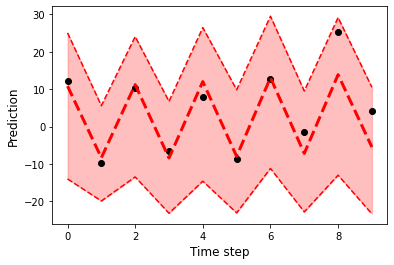

In [80]:
plt.fill_between(range(len(y)), y_l_approx[0], y_u_approx[0], color="r", alpha=0.25)
plt.plot(y_l_approx[0], linestyle="--", color="r")
plt.plot(y_u_approx[0], linestyle="--", color="r")
plt.plot(y_pred[0], linestyle="--", linewidth=3, color="r")

plt.scatter(range(len(y)), y, color="black")

plt.xlabel("Time step", fontsize=12)
plt.ylabel("Prediction", fontsize=12)

Here, the black dots correspond to the original test labels, the red line corresponds to the RNN predictions and the shaded area corresponds to the sequential confidence intervals. As we can see, because the noise variance increases progressively over the time steps, the RNN predictions deviates more and more over time, and the corresponding confidence intervals widen. 